In [1]:
import numpy as np
from PIL import Image
from medpy.filter.smoothing import anisotropic_diffusion
import cv2

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sys.path.insert(0,'..')

In [3]:
def histogram_t(tb):
    '''
    Histogram equalization
    '''
    totalpixel=0    
    maptb=[]        
    count=len(tb)
    for i in range(count):
        totalpixel+=tb[i]
        maptb.append(totalpixel)

    for i in range(count):
        maptb[i]=int(round((maptb[i]*(count-1))/totalpixel))
   
    def histogram(light):
        return maptb[light]
    return histogram

Przykładowy preprocessing

In [4]:
#Do zobaczenia
"7848bf2d6be7318bf1457253990d25_jumbo.jpeg"
"5A78BCA9-5B7A-440D-8A4E-AE7710EA6EAD-2048x1661.jpeg"
"a092a272b78ce7c23e6a490721b750_jumbo.jpeg"

'a092a272b78ce7c23e6a490721b750_jumbo.jpeg'

In [5]:
test_path = '../Example_Images/5A78BCA9-5B7A-440D-8A4E-AE7710EA6EAD-2048x1661.jpeg' 

In [6]:
img = Image.open(test_path)

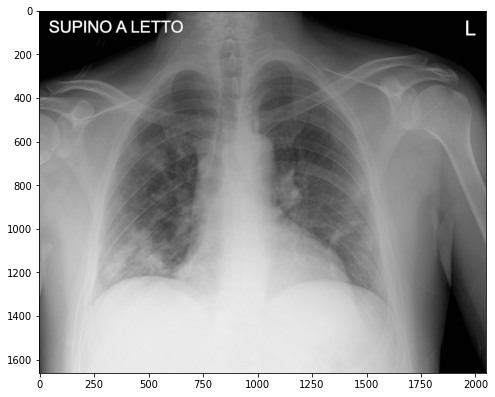

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap=cm.gray)

In [8]:
img.size

(2048, 1661)

In [9]:
resized = img.resize((1024,1024), Image.ANTIALIAS)

Rozciąganie histogramu

In [10]:
his = resized.histogram() #histogram
hisfunc = histogram_t(his) 
img_hist = resized.point(hisfunc)

Redukcja zaszumienia

In [11]:
img_np = np.array(img_hist)/255
if img_np.ndim == 3:
    img_np = img_np[:,:,0]
cleaned = anisotropic_diffusion(img_np)

C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


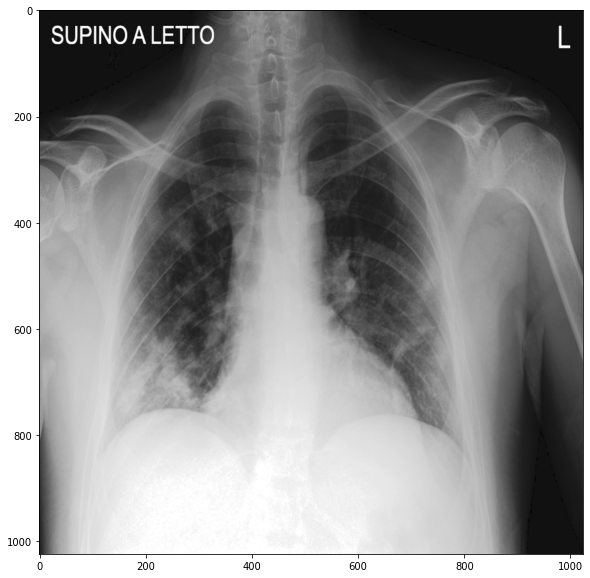

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(cleaned, cmap=cm.gray)

In [13]:
converted = cv2.normalize(cleaned, None, alpha = 0, beta = 255,
                          norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8)
mask = cv2.threshold(converted, 220, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
mask = cv2.dilate(mask, kernel)
result = cv2.inpaint(converted, mask, 10, cv2.INPAINT_NS)

Maska

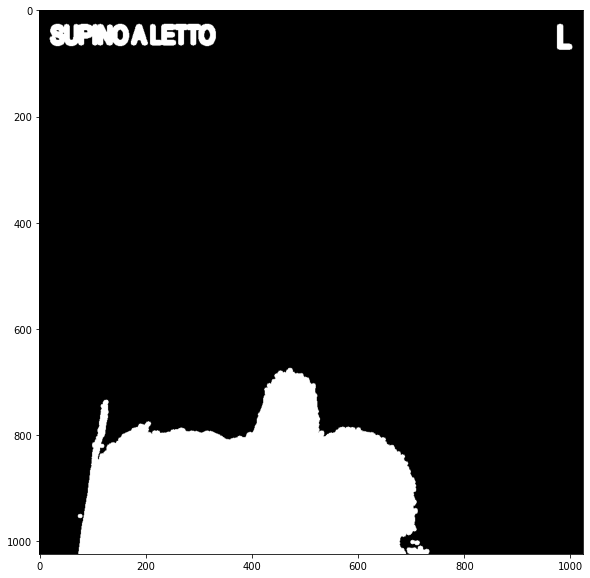

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(mask, cmap=cm.gray)

Wyjściowe zdjęcie

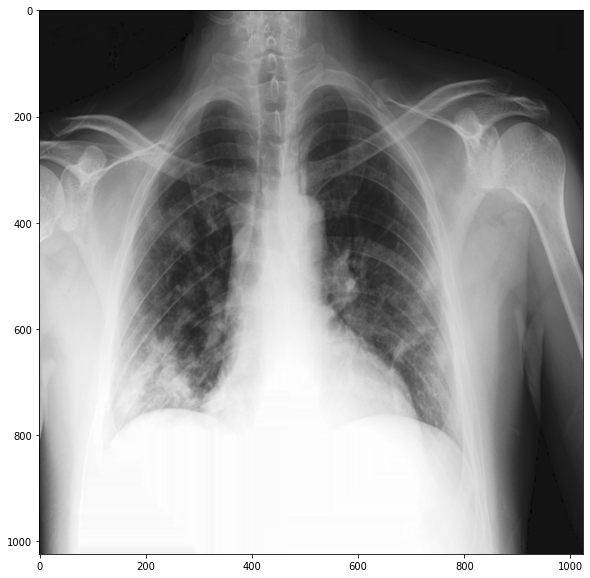

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(result, cmap=cm.gray)

Skrypt do preprocessingu wszystkich zdjęć

In [16]:
stop here #bardzo duże wymagania pamięci operacyjnej

SyntaxError: invalid syntax (<ipython-input-16-a96ba3aab008>, line 1)

In [ ]:
import pandas as pd

df_test = pd.read_csv('test_split.txt',
                 delimiter = " ",
                index_col=False)
df_test.columns = ["number", "filename", "illness", "data"]

df_train = pd.read_csv('train_split.txt',
                 delimiter = " ",
                index_col=False)
df_train.columns = ["number", "filename", "illness", "data"]

dict_test = pd.Series(df_test.illness.values,index=df_test.filename).to_dict() 
dict_train = pd.Series(df_train.illness.values,index=df_train.filename).to_dict()

In [ ]:
#import os
#from PIL import Image
#import numpy as np

img_path = os.path.join("data2", "train")
names = df_train["filename"]

def load_images(names):
    n_images = len(names)
    images = np.zeros((n_images, 1024, 1024, 3))
    labels = np.empty(n_images, dtype='object')
    for i in range(n_images):
        name = names[i]
        image = Image.open(os.path.join(img_path, name))
        image = image.convert('RGB').resize((1024,1024), Image.ANTIALIAS) #resize with AA
        image = np.asarray(image)
        images[i] = image
        labels[i] = dict_train[name]
    return images, labels

In [ ]:
np.random.seed(2137)

df1 = df_train[df_train["illness"]=="normal"].sample(110)["filename"]
df2 = df_train[df_train["illness"]=="COVID-19"].sample(110)["filename"]
df3 = df_train[df_train["illness"]=="pneumonia"].sample(110)["filename"]
frames = [df1.head(100), df2.head(100), df3.head(100)]
frames2 = [df1.tail(10), df2.tail(10), df3.tail(10)]

names_train = pd.concat(frames).reset_index(drop=True)
names_test = pd.concat(frames2).reset_index(drop=True)

In [ ]:
def encode(y):
    y[y=="normal"]=0
    y[y=="COVID-19"]=1
    y[y=="pneumonia"]=2
    return y.astype(int)

In [ ]:
names = names_train
x_train, y_train = load_images(names)

names = names_test
x_test, y_test = load_images(names)

y_train = encode(y_train)
y_test = encode(y_test)

In [ ]:
x_train.shape

In [ ]:
x_train1 = np.empty((300, 224, 224, 3))

In [ ]:
def preprocess_image(image):
    #for image 1024 x 1024
    img = Image.fromarray(image)
    his = img.histogram()
    hisfunc = histogram_t(his) 
    img_hist = img.point(hisfunc)
    img_np = np.array(img_hist)/255
    if img_np.ndim == 3:
        img_np = img_np[:,:,0]
    cleaned = anisotropic_diffusion(img_np)
    converted = cv2.normalize(cleaned, None, alpha = 0, beta = 255,
                          norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8)
    mask = cv2.threshold(converted, 140, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    mask = cv2.dilate(mask, kernel)
    result = cv2.inpaint(converted, mask, 10, cv2.INPAINT_NS)
    result1 = Image.fromarray(result).convert('RGB').resize((224,224))
    result2 = np.asarray(result1)
    return result2

In [ ]:
for i in range(len(x_train)):
    x_train1[i] = preprocess_image(x_train[1].astype(np.uint8))

In [ ]:
x_train1.shape

In [ ]:
# zapis do pliku
np.save("preprocessed/x_train_prep.npy", x_train1)
np.save("preprocessed/y_train_prep.npy", y_train)